# Start

In [1]:
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


read_parameter_card = """
read parameter card
* methanol
*
NONBONDED
CG321    0.0       {CG321EP:.4f}     {CG321RM:.4f}   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       {CLGA1EP:.4f}    {CLGA1RM:.4f} ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       {HGA2EP:.4f}    {HGA2RM:.4f} ! alkane, yin and mackerell, 4/98
END
"""
# HGA2     0.0       -0.0200     1.3400 ! alkane, yin and mackerell, 4/98


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)


import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view


from scipy.optimize import minimize

ev2kcalmol = 1 / (ase.units.kcal / ase.units.mol)

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2RM = 1.3400 

def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)

    with open("total.dmat") as f:
        output_dmat = f.read()

    atom_number_type_dict = {}
    atom_number_resid_dict = {}

    pair_distance_dict = {}
    pair_resid_dict = {}

    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()

            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1

    for _ in output_dmat.split("\n"):
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if atom_number_resid_dict[a] < atom_number_resid_dict[b]:
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (
                    atom_number_resid_dict[a],
                    atom_number_resid_dict[b],
                )

    return {
        "atom_number_type_dict": atom_number_type_dict,
        "atom_number_resid_dict": atom_number_resid_dict,
        "pair_distance_dict": pair_distance_dict,
        "pair_resid_dict": pair_resid_dict,
    }


def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces


def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations


def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations


def calc_pycharmm_dimers(n_mol=20, n_atoms=5, forces=False):
    RANGE = len(dimer_permutations(n_mol))

    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms * n_mol, 3))

    for i, (a, b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f

        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {
        "ele_energies": ele_energies,
        "evdw_energies": evdw_energies,
        "mm_forces": mm_forces,
    }


def reset_block():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


def reset_block_no_internal():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()


import MDAnalysis as mda


def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    atypes = psf.get_atype()
    atc = pycharmm.param.get_atc()
    residues = psf.get_res()
    psf.get_natom()
    # nl_info = capture_neighbour_list()

    # TODO: this assumes a pure system, need to update
    atoms_per_res = int(len(atypes) / len(residues))
    n_res = len(residues)
    resids = np.array([[i] * atoms_per_res for i in range(n_res)]).flatten()
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array(
        [ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names]
    )
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {
        (a - 1, b): i for i, (a, b) in enumerate(zip(mda_resids, atom_names))
    }
    charmm_res_at_dict = {(a, b): i for i, (a, b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k, v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k, v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array(
        [charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))]
    )
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

    return {
        "atom_names": atom_names,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
        "mda_resids": mda_resids,
        "mda_res_at_dict": mda_res_at_dict,
        "charmm_res_at_dict": charmm_res_at_dict,
        "an_charmm_res_at_dict": an_charmm_res_at_dict,
        "an_mda_res_at_dict": an_mda_res_at_dict,
        "atom_positions": atom_positions,
        "reorder": reorder,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
    }


def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda


epsilon = 10 ** (-6)
from e3x.nn import smooth_switch, smooth_cutoff


def combine_with_sigmoid(
    r,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=5.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)

    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy
    mm_contrib = mm_contrib * charmm_off_scale

    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate(
        [
            np.arange(0, n_atoms, 1) + (a - 1) * n_atoms,
            np.arange(0, n_atoms, 1) + (b - 1) * n_atoms,
        ]
    )


def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol + 1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a - 1) * n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))

    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])

        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()

    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, all_monomer_idxs, R):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a, b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0]  # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0]  # TODO: generalize...
        out_dists[i] = np.linalg.norm(R[a] - R[b])

    return out_dists


def setup_ase_atoms(atomic_numbers, positions, n_atoms):
    """Create and setup ASE Atoms object with centered positions"""
    Z = [_ for i, _ in enumerate(atomic_numbers) if i < n_atoms]
    R = np.array([_ for i, _ in enumerate(positions) if i < n_atoms])
    atoms = ase.Atoms(Z, R)
    # translate to center of mass
    # atoms.set_positions(R - R.T.mean(axis=1))
    return atoms


def create_physnet_calculator(params, model, atoms, ev2kcalmol):
    """Create PhysNet calculator with specified parameters"""
    calc = get_ase_calc(
        params,
        model,
        atoms,
        conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol},
    )
    atoms.calc = calc
    return atoms


def initialize_models(restart_path, N_ATOMS_MONOMER):
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)

    # Setup monomer model
    params, monomer_model = get_params_model(restart)
    monomer_model.natoms = N_ATOMS_MONOMER

    # Setup dimer model
    params, dimer_model = get_params_model(restart)
    dimer_model.natoms = N_ATOMS_MONOMER * 2

    return params, monomer_model, dimer_model


def get_rmse_mae(energy, ref_energy):
    rmse = np.sqrt(np.mean((energy - ref_energy) ** 2))
    mae = np.mean(np.abs(energy - ref_energy))
    return rmse, mae


def print_energy_comparison(mmml_energy, charmm, ref_energy):
    """Print comparison of energies with reference data"""

    print("comb")
    print(mmml_energy, ref_energy, abs(mmml_energy - ref_energy))

    print("charmm")
    print(charmm, ref_energy, abs(charmm - ref_energy))


def calculate_E_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM energies"""
    summed_ml_intE = dimer_results["ml_energies"] - monomer_results["ml_energies"][
        np.array(dimer_idxs)
    ].sum(axis=1)
    summed_mm_intE = result["ele_energies"] + result["evdw_energies"]
    return summed_ml_intE, summed_mm_intE

def calculate_F_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM forces"""
    mono = monomer_results["ml_forces"][
        np.array(dimer_idxs)
    ]
    print(mono.shape)
    a,b,c,d = mono.shape
    mono = mono.reshape(a, b*c, d)
    summed_ml_intF = dimer_results["ml_forces"] - mono
    summed_mm_intF = result["mm_forces"]
    return summed_ml_intF, summed_mm_intF

def get_fnkey(fn):
    fnkey = str(fn).split("/")[-1].split(".")[0].upper()
    fnkey = "_".join(fnkey.split("_")[:3])
    return fnkey

def calc_energies_forces(
    fn, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    set_pycharmm_xyz(atom_positions)
    energy.show()

    ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)
    
    result = None
    summed_2body = None
    mmml_energy = None
    charmm = None

    if DO_MM:
        # Calculate CHARMM energies and forces first
        result = calc_pycharmm_dimers(forces=True)
        summed_2body = result["mm_forces"].sum(axis=0)
        mm_forces = result["mm_forces"]

    all_coordinates = ase_atom_full_system.get_positions()
    dimer_idxs = dimer_permutations(20)

    dimer_pair_c_c_distances = get_dimer_distances(
        dimer_idxs, all_monomer_idxs, all_coordinates
    )

    if DO_ML:
        dimer_results = calc_physnet_via_idx_list(
            all_coordinates, all_dimer_idxs, ase_atoms_dimer
        )

        monomer_results = calc_physnet_via_idx_list(
            all_coordinates, all_monomer_idxs, ase_atoms_monomer
        )

        # Calculate ML and MM energies
        summed_ml_intE, summed_mm_intE = calculate_E_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

        summed_ml_intF, summed_mm_intF = calculate_F_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

    if DO_MM and DO_ML:
        combined_with_switches = combine_with_sigmoid(
            dimer_pair_c_c_distances,
            summed_mm_intE,
            summed_ml_intE,
            MM_CUTON=MM_CUTON,
            MM_CUTOFF=MM_CUTOFF,
            BUFFER=BUFFER,
        )
        (
            mm_contrib,
            ml_contrib,
            charmm_off_scale,
            charmm_on_scale,
            ml_scale,
        ) = combined_with_switches

        mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
        charmm = float(summed_mm_intE.sum())
    else:
        mmml_energy = float(summed_ml_intE.sum())
        charmm = float(summed_mm_intE.sum())

    print(summed_ml_intE.shape, summed_mm_intE.shape)

    mm_forces = summed_mm_intF
    ml_forces = summed_ml_intF


    indices = np.array(all_dimer_idxs).flatten()[:, None].repeat(3, axis=1) + np.array([0, mm_forces.shape[1],  2*mm_forces.shape[1]])
    flattened_ml_dimers = ml_forces.reshape(-1, 3).flatten()
    # indices = np.repeat(np.array(all_dimer_idxs).flatten(), 3)
    mmml_forces = jax.ops.segment_sum(flattened_ml_dimers, indices.flatten()).reshape(mm_forces.shape[1], 3)
    
    # mmml_forces = (mm_forces, ml_forces)


    output_dict = {
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }

    return output_dict

def compare_energies(
    fn,  df, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    energy_forces_dict = calc_energies_forces(fn, DO_ML=DO_ML, DO_MM=DO_MM, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
    mmml_energy = energy_forces_dict["mmml_energy"]
    charmm = energy_forces_dict["charmm"]
    mm_forces = energy_forces_dict["mm_forces"]
    ml_forces = energy_forces_dict["ml_forces"]
    mmml_forces = energy_forces_dict["mmml_forces"]

    # print(fn)
    fnkey = get_fnkey(fn)
    # print(fnkey)
    # print(df)
    if fnkey in df["key"].values:
        df = df[df["key"] == fnkey]
        # print(df)
        ref_energy = df.iloc[0]["Formation Energy (kcal/mol)"]
        if DO_MM:
            err_mmml = mmml_energy - ref_energy
            err_charmm = charmm - ref_energy
        else:
            err_mmml = mmml_energy - ref_energy
            err_charmm = None
    else:
        ref_energy = None
        err_mmml = None
        err_charmm = None

    results_dict = {
        "ref_energy": ref_energy,
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "err_mmml": err_mmml,
        "err_charmm": err_charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }
    return results_dict


def set_param_card(CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM):
    cmd = "PRNLev 5\nWRNLev 5"
    param_card = read_parameter_card.format(
        CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM
    )
    print(param_card)
    pycharmm.lingo.charmm_script(param_card)
    cmd = "PRNLev 0\nWRNLev 0"
    pycharmm.lingo.charmm_script(cmd)


def get_loss_terms(fns, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.01, MM_lambda=1.0, ML_lambda=0.0, DO_MM=True, DO_ML=True):
    import time

    start = time.time()
    err_mmml_list = []
    err_charmm_list = []
    for fn in fns:
        results_dict = compare_energies(fn, df, DO_MM=DO_MM, DO_ML=DO_ML, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
        err_mmml_list.append(results_dict["err_mmml"])
        err_charmm_list.append(results_dict["err_charmm"])
        print(
            "{} {:.1f} {:.1f} {:.1f} {:.1f} {:.1f}".format(
                fn.stem,
                results_dict["ref_energy"],
                results_dict["mmml_energy"],
                results_dict["charmm"],
                results_dict["err_mmml"],
                results_dict["err_charmm"],
            )
        )

    end = time.time()
    print("Finished")
    print("Time taken", end - start)
    print("--------------------------------")
    err_mmml_list = np.array(err_mmml_list)
    err_charmm_list = np.array(err_charmm_list)

    print("RMSE MMML", np.sqrt(np.mean(err_mmml_list**2)))
    print("MAE MMML", np.mean(np.abs(err_mmml_list)))
    print("RMSE Charmm", np.sqrt(np.mean(err_charmm_list**2)))
    print("MAE Charmm", np.mean(np.abs(err_charmm_list)))

    loss = MM_lambda * np.mean(err_mmml_list**2) + ML_lambda * np.mean(err_charmm_list**2)
    return loss, err_mmml_list, err_charmm_list

def get_loss_fn(train_filenames, DO_ML=True, DO_MM=True, NTRAIN=20, MM_CUTON=6.0, MM_lambda=1.0, ML_lambda=0.0):
    def loss_fn(x0):
        print("Starting")
        # random_indices = np.random.randint(0, len(train_filenames),6)
        fns = [train_filenames[i] for i in range(NTRAIN)]
        CG321EP, CG321RM, CLGA1EP, CLGA1RM = x0[:4]
        set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
        loss, _, _ = get_loss_terms(fns, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda, DO_MM=DO_MM, DO_ML=DO_ML)
        print("Loss", loss)
        return loss
    return loss_fn


def ep_scale_loss(x0):
    print("Starting")
    random_indices = np.random.randint(0, len(train_filenames), 4)
    fns = [train_filenames[i] for i in random_indices]
    ep_scale = float(x0)
    set_param_card(CG321EP * ep_scale, CG321RM, CLGA1EP * ep_scale, CLGA1RM)
    loss, _, _ = get_loss_terms(fns)
    print("Loss", loss)
    return loss

def create_initial_simplex(x0, delta=0.0001):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.0001,  # Absolute tolerance on x
            "fatol": 0.0001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.1):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

def get_block(a,b):
    block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
"""
    return block


@jit
def switch_MM(    X,
    mm_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    mm_contrib = charmm_on_scale * mm_energy * charmm_off_scale
    return mm_contrib



@jit
def switch_ML(X,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy
    return ml_contrib.sum()

switch_ML_grad = jax.grad(switch_ML)
switch_MM_grad = jax.grad(switch_MM)


@jit
def combine_with_sigmoid_E(
    X,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ml_contrib = switch_ML(X,ml_energy)
    mm_contrib = switch_ML(X,mm_energy)
    return mm_contrib + ml_contrib


# DATA
###################################################################
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

print(df)


pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)
# pycharmm.lingo.charmm_script(load_dcm)
reset_block_no_internal()






[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-04-05 17:59:47.985757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743868788.007406  242809 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743868788.014165  242809 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 17:59:56.926455: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coeff

        Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key  
0                    -41.731

In [2]:


def get_dimer_calculator(
    atomic_numbers, 
    atom_positions,
    MM_CUTON = 6.0,
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """
    N_ATOMS_MONOMER = 5
    N_MONOMERS = 2

    params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

    # Setup monomer calculator
    ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
    ase_atoms_monomer = create_physnet_calculator(
        params, monomer_model, ase_atoms_monomer, ev2kcalmol
    )

    # Setup dimer calculator
    ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
    ase_atoms_dimer = create_physnet_calculator(
        params, dimer_model, ase_atoms_dimer, ev2kcalmol
    )

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))

    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)


    def calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer):
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[:N_ATOMS_MONOMER].T.mean(axis=1) - R[N_ATOMS_MONOMER:].T.mean(axis=1))
        takeidx = 0

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R   
        set_pycharmm_xyz(tmp_coord)
        reset_block()
        a, b = 1, 2  # Select first two residues
        block = get_block(a,b)
        _ = pycharmm.lingo.charmm_script(block)
        energy.show()
        ref_forces_mm = get_forces_pycharmm()

        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()

        # Calculate ML dimer energy and forces
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()

        # Calculate ML monomer 1 energy and forces
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        # Calculate ML monomer 2 energy and forces
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()

        # Calculate force errors relative to reference
        ase_dimer_forces = np.array(ase_dimer_F) 
        # Combine monomer forces and calculate errors
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        # Calculate mixed 1-body/2-body forces and errors
        mixed_1b2b = (2 * ase_dimers_1body_forces) - ase_dimer_forces 

        # Calculate interaction energy (difference between dimer and monomers)
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E  # Interaction energy without MM
        # Apply switching functions to combine ML and MM energies
        final_e1 = combine_with_sigmoid_E(R, chm_d_E, final_energy)
        # Add monomer contributions to final energy
        final_energy = final_e1 + (ase_monomer_E1 + ase_monomer_E2)
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R, chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R, final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R, chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R, final_energy)  # ML switching gradient
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]
        # Combine forces with switching functions
        ml_forces_out = (ase_dimers_1body_forces - ase_dimer_forces) * val_ml_s + grad_ml_s * final_energy 
        mm_forces_out = (chm_ref_dimers) * val_mm_s + grad_mm_s * chm_d_E
        # Combine all force contributions for final forces
        final_forces = ml_forces_out + mm_forces_out + ase_dimers_1body_forces

        outdict = {
            "energy": final_energy,
            "forces": final_forces,
            "dH": final_e1,
            "r_COM": r,
            "charmm_energy": chm_d_E,
            "ml_dimer_energy": ase_dimer_E,
            "ml_monomer_energy_1": ase_monomer_E1,
            "ml_monomer_energy_2": ase_monomer_E2,
            "ml_interaction_energy": (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E,
            "val_mm_s": val_mm_s,
            "val_ml_s": val_ml_s,
            "grad_mm_s": grad_mm_s,
            "grad_ml_s": grad_ml_s,
            "ml_forces_out": ml_forces_out,
            "mm_forces_out": mm_forces_out,
            "ml_dimer_forces": ase_dimer_forces,
            "ml_1body_forces": ase_dimers_1body_forces,
            "charmm_forces": chm_ref_dimers,
            "mixed_1b2b_forces": mixed_1b2b,
        }

        return outdict



    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            output = calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer)
            self.results["energy"] = output[
                "energy"
            ].squeeze()   * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = output[
                "forces"
            ]  * (ase.units.kcal/ase.units.mol)

            # for k, v in output.items():
            #     print(k)
            #     print(np.array(v))

    return AseDimerCalculator(), ase_atoms_monomer, ase_atoms_dimer

In [3]:


def get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,
    MM_CUTON = 14.0,
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """
    N_ATOMS_MONOMER = 5
    N_MONOMERS = 20

    params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

    # Setup monomer calculator
    ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
    ase_atoms_monomer = create_physnet_calculator(
        params, monomer_model, ase_atoms_monomer, ev2kcalmol
    )

    # Setup dimer calculator
    ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
    ase_atoms_dimer = create_physnet_calculator(
        params, dimer_model, ase_atoms_dimer, ev2kcalmol
    )

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(20)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)
    
       
    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)

    def calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer, add_1B=False):
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[:N_ATOMS_MONOMER].T.mean(axis=1) - R[N_ATOMS_MONOMER:].T.mean(axis=1))

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R   
        set_pycharmm_xyz(tmp_coord)
        energy.show()
        reset_block_no_internal()
        a,b=1,2
        block = get_block(a,b)
        _ = pycharmm.lingo.charmm_script(block)
        
        energy.show()
        ref_forces_mm = get_forces_pycharmm()
        
        # chm_d_E = 0
        # final_energy = 0
        # chm_ref_dimers = np.zeros((10,3))
        
        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()
        
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]

        
        # Calculate ML dimer energy and forces
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()

        # Calculate ML monomer 1 energy and forces
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        # Calculate ML monomer 2 energy and forces
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()

        # Calculate force errors relative to reference
        ase_dimer_forces = np.array(ase_dimer_F) 
        # Combine monomer forces and calculate errors
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        # Calculate mixed 1-body/2-body forces and errors
        mixed_1b2b = (2 * ase_dimers_1body_forces) - ase_dimer_forces 

        # Calculate interaction energy (difference between dimer and monomers)
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E  # Interaction energy without MM
        
        # # Apply switching functions to combine ML and MM energies
        # final_e1 = combine_with_sigmoid_E(R, chm_d_E, final_energy)

        # final_energy = final_e1 

        final_forces = 0
        ml_forces_out = 0
        ml_f = (ase_dimers_1body_forces - ase_dimer_forces) 
 
        
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R, chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R, final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R, chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R, final_energy)  # ML switching gradient

        # Combine forces with switching functions
        ml_forces_out = ml_f * val_ml_s + grad_ml_s * final_energy 
        if add_1B:
            ml_forces_out += ase_dimers_1body_forces   
            # Add monomer contributions to final energy
            final_energy += (ase_monomer_E1 + ase_monomer_E2)
        mm_forces_out = chm_ref_dimers * val_mm_s + grad_mm_s * chm_d_E
        
        # Combine all force contributions for final forces
        final_forces += ml_forces_out + mm_forces_out #+ ase_dimers_1body_forces
        


        outdict = {
            "energy": final_energy,
            "forces": final_forces,
            # "dH": final_e1,
            # "r_COM": r,
            # "charmm_energy": chm_d_E,
            # "ml_dimer_energy": ase_dimer_E,
            # "ml_monomer_energy_1": ase_monomer_E1,
            # "ml_monomer_energy_2": ase_monomer_E2,
            # "ml_interaction_energy": (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E,
            # "val_mm_s": val_mm_s,
            # "val_ml_s": val_ml_s,
            # "grad_mm_s": grad_mm_s,
            # "grad_ml_s": grad_ml_s,
            # "ml_forces_out": ml_forces_out,
            # "mm_forces_out": mm_forces_out,
            # "ml_dimer_forces": ase_dimer_forces,
            # "ml_1body_forces": ase_dimers_1body_forces,
            # "charmm_forces": chm_ref_dimers,
            # "mixed_1b2b_forces": mixed_1b2b,
        }

        return outdict

    def spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer):
        output = []
        for i, idx in enumerate(all_dimer_idxs):
            do_1B = False
            if collect_monomers[i] == 1:
                do_1B = True
                # print(i, dimer_perms[i])
            output.append(
            calc_dimer_energy_forces(
                R[idx], Z[idx], ase_atoms_dimer, ase_atoms_monomer,  
                add_1B=do_1B))
            # Set up CHARMM coordinates and calculate MM energy
            tmp_coord = coor.get_positions().to_numpy() * 0
            tmp_coord[:len(R), :] = R   
            set_pycharmm_xyz(tmp_coord)
            
        out_E = 0
        out_F = np.zeros((N_ATOMS_MONOMER*N_MONOMERS, 3))
        for i, _ in enumerate(output):
            out_E += output[i]["energy"]
            out_F[all_dimer_idxs[i]] += output[i]["forces"]
            # if output[i]["energy"] < -200:
            #     print(dimer_perms[i], collect_monomers[i], all_dimer_idxs[i])
            #     print(output[i]["energy"])
            #     print(np.array(output[i]["forces"]))
        
        return {"energy": out_E, "forces": out_F}
    



    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            out = spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer)
            self.results["energy"] = out["energy"]  * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = out["forces"] * (ase.units.kcal/ase.units.mol)


    return AseDimerCalculator(), ase_atoms_monomer, ase_atoms_dimer

In [4]:
# pdb_data_mda

In [5]:
CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2ERM = 1.3400 

In [6]:
# def set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM):
#     cmd = "PRNLev 5\nWRNLev 5"
#     param_card = read_parameter_card.format(
#         CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM
#     )
#     print(param_card)
#     pycharmm.lingo.charmm_script(param_card)
#     cmd = "PRNLev 0\nWRNLev 0"
#     pycharmm.lingo.charmm_script(cmd)

In [7]:
set_param_card()


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       -0.0200    1.3400 ! alkane, yin and mackerell, 4/98
END

  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANOL
 RDTITL> *
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   1  CG331   
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   2  HGP1    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   3  HGA3    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   4  OG311   
 NO nonbond interactions will be computed for this 

In [8]:
NBL = capture_neighbour_list()

In [9]:
NBL["pair_resid_dict"]

{(0, 5): (0, 1),
 (0, 6): (0, 1),
 (0, 7): (0, 1),
 (0, 8): (0, 1),
 (0, 9): (0, 1),
 (0, 10): (0, 2),
 (0, 11): (0, 2),
 (0, 12): (0, 2),
 (0, 13): (0, 2),
 (0, 14): (0, 2),
 (0, 15): (0, 3),
 (0, 16): (0, 3),
 (0, 17): (0, 3),
 (0, 18): (0, 3),
 (0, 19): (0, 3),
 (0, 20): (0, 4),
 (0, 21): (0, 4),
 (0, 22): (0, 4),
 (0, 23): (0, 4),
 (0, 24): (0, 4),
 (0, 25): (0, 5),
 (0, 26): (0, 5),
 (0, 27): (0, 5),
 (0, 28): (0, 5),
 (0, 29): (0, 5),
 (0, 30): (0, 6),
 (0, 31): (0, 6),
 (0, 32): (0, 6),
 (0, 33): (0, 6),
 (0, 34): (0, 6),
 (0, 35): (0, 7),
 (0, 36): (0, 7),
 (0, 37): (0, 7),
 (0, 38): (0, 7),
 (0, 39): (0, 7),
 (0, 40): (0, 8),
 (0, 41): (0, 8),
 (0, 42): (0, 8),
 (0, 43): (0, 8),
 (0, 44): (0, 8),
 (0, 45): (0, 9),
 (0, 46): (0, 9),
 (0, 47): (0, 9),
 (0, 48): (0, 9),
 (0, 49): (0, 9),
 (0, 50): (0, 10),
 (0, 51): (0, 10),
 (0, 52): (0, 10),
 (0, 53): (0, 10),
 (0, 54): (0, 10),
 (0, 55): (0, 11),
 (0, 56): (0, 11),
 (0, 57): (0, 11),
 (0, 58): (0, 11),
 (0, 59): (0, 11),
 (0, 

In [10]:
NBL.keys()

dict_keys(['atom_number_type_dict', 'atom_number_resid_dict', 'pair_distance_dict', 'pair_resid_dict'])

In [11]:
at_to_param = {"C": "CG321", "CL1": "CLGA1", "CL2": "CLGA1", "H1": "HGA2" , "H2": "HGA2" }

params =  ["CG321", "CLGA1", "HGA2"]
params.sort()
at_ep = {"CG321": CG321EP, "CLGA1":CLGA1EP , "HGA2": HGA2EP}
at_rm = {"CG321": CG321RM, "CLGA1":CLGA1RM , "HGA2": HGA2RM}
at_q = {"CG321": -0.018, "CLGA1": -0.081 , "HGA2": 0.09}

In [12]:
# CG321EP = -0.0560
# CG321RM = 2.0100
# CLGA1EP = -0.3430
# CLGA1RM = 1.9100
# HGA2EP = 0 # -0.0200  
# HGA2RM = 0 #1.3400 
at_ep = {"CG321": CG321EP, "CLGA1":CLGA1EP , "HGA2": HGA2EP}
at_rm = {"CG321": CG321RM, "CLGA1":CLGA1RM , "HGA2": HGA2RM}
at_q = {"CG321": -0.018, "CLGA1": -0.081 , "HGA2": 0.09}

In [13]:
from itertools import combinations, permutations, product

at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]
at_perms

[('CG321', 'CG321'),
 ('CG321', 'CLGA1'),
 ('CG321', 'HGA2'),
 ('CLGA1', 'CLGA1'),
 ('CLGA1', 'HGA2'),
 ('HGA2', 'HGA2')]

In [14]:
# param_card = read_parameter_card.format(
#     CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM
# )
# print(param_card)
# pycharmm.lingo.charmm_script(param_card)
# charges

In [15]:
charges = psf.get_charges()
masses = psf.get_amass()
at_codes = psf.get_iac()
atomtype_codes = psf.get_atype()
# psf?

In [16]:
set_param_card?
# atomtype_codes

Signature:
set_param_card(
    CG321EP=-0.056,
    CG321RM=2.01,
    CLGA1EP=-0.343,
    CLGA1RM=1.91,
    HGA2EP=-0.02,
    HGA2RM=1.34,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_242809/1199811920.py
Type:      function

In [17]:
NBL["pair_distance_dict"].keys()

dict_keys([(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), 

In [18]:
R = coor.get_positions().to_numpy()
pair_idxs_product = np.array([(a,b) for a,b in list(product(np.arange(5), repeat=2))])
dimer_perms = np.array(dimer_permutations(20))

pair_idxs_np = dimer_perms * 5
pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
pair_idx_atom_atom = pair_idx_atom_atom[(pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])]
displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
distances = np.linalg.norm(displacements, axis=1)
distances.shape

(4750,)

In [19]:
# pair_idxs_product

In [20]:
# dimer_perms

In [21]:
# pair_idx_atom_atom.shape, (pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1]).shape

In [22]:
np.array(list(NBL["pair_distance_dict"].keys())), pair_idx_atom_atom

(array([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        ...,
        [94, 97],
        [94, 98],
        [94, 99]]),
 array([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        ...,
        [94, 97],
        [94, 98],
        [94, 99]]))

In [23]:
np.array(list(NBL["pair_distance_dict"].keys())).shape

(4750, 2)

In [24]:
comparison = np.array(list(NBL["pair_distance_dict"].keys())) == pair_idx_atom_atom


In [25]:
pair_idx_atom_atom

array([[ 0,  5],
       [ 0,  6],
       [ 0,  7],
       ...,
       [94, 97],
       [94, 98],
       [94, 99]])

# Validation with pure python
## NO mda analysis or reading/writing to disk

In [26]:
# NBL = capture_neighbour_list()

from itertools import combinations, permutations, product

R = coor.get_positions().to_numpy()
pair_idxs_product = np.array([(a,b) for a,b in list(product(np.arange(5), repeat=2))])
dimer_perms = np.array(dimer_permutations(20))

pair_idxs_np = dimer_perms * 5
pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
pair_idx_atom_atom = pair_idx_atom_atom[(pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])]
displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
distances = np.linalg.norm(displacements, axis=1)
distances.shape


at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2RM = 1.3400 

set_param_card(    
    CG321EP=CG321EP,
    CG321RM=CG321RM,
    CLGA1EP=CLGA1EP,
    CLGA1RM=CLGA1RM,
    HGA2EP=HGA2EP,
    HGA2RM=HGA2RM,)

at_to_param = {"C": "CG321", "CL1": "CLGA1", "CL2": "CLGA1", "H1": "HGA2" , "H2": "HGA2" }

params =  ["CG321", "CLGA1", "HGA2"]
params.sort()
at_ep = {"CG321": CG321EP, "CLGA1":CLGA1EP , "HGA2": HGA2EP}
at_rm = {"CG321": CG321RM, "CLGA1":CLGA1RM , "HGA2": HGA2RM}
at_q = {"CG321": -0.018, "CLGA1": -0.081 , "HGA2": 0.09}

charges = psf.get_charges()
masses = psf.get_amass()
at_codes = psf.get_iac()
atomtype_codes = psf.get_atype()

at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]
at_perms_ep, at_perms_rm

NBL = {}
NBL["atom_number_type_dict"] = {k: v for k,v in enumerate(atomtype_codes)}
NBL["pair_at_dict"] = {}
NBL["pair_at_idx_dict"] = {}
NBL["pair_ep"] = {}
NBL["pair_rm"] = {}
NBL["pair_valid"] = {}
NBL["pair_qq"] = {}
NBL["pair_distance_dict"] = {tuple(k): v for k,v in zip(pair_idx_atom_atom, distances)}

for k in pair_idx_atom_atom:
    k = tuple(k)
    a,b = k
    atom_a, atom_b = NBL["atom_number_type_dict"][a], NBL["atom_number_type_dict"][b]
    atom_a, atom_b = at_to_param[atom_a], at_to_param[atom_b]
    valid_keys = None
    if (atom_a, atom_b) in at_perms:
        valid_keys = (atom_a, atom_b)
    elif (atom_b, atom_a) in at_perms:
        valid_keys = (atom_b, atom_a) 
    else:
        print(atom_a, atom_b)
        raise Exception()
        
    NBL["pair_at_dict"][k] = valid_keys
    at_index = at_perms.index(valid_keys)
    NBL["pair_at_idx_dict"][k] = at_index
    NBL["pair_ep"][k] = at_perms_ep[at_index]
    NBL["pair_rm"][k] = at_perms_rm[at_index]
    NBL["pair_qq"][k] = at_perms_qq[at_index]
    NBL["pair_valid"][k] = (a // 5) != (b // 5)

def LJ(sig, ep, r):
    """
    rmin = 2^(1/6) * sigma
        https://de.wikipedia.org/wiki/Lennard-Jones-Potential
    Lennard-Jones potential for a pair of atoms
    """
    a = 6
    b = 2
    # sig = sig / (2 ** (1 / 6))
    r6 = (sig / r) ** a
    return ep * (r6 ** b - 2 * r6)

LJ_grad = jax.grad(LJ, argnums=2)


coloumns_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
def Coloumb(qq, r, constant = coloumns_constant):
    return constant * qq/r

Coloumb_grad = jax.grad(LJ, argnums=1)

atom_keys = list(NBL["pair_distance_dict"].keys())
rmins = np.array([ NBL["pair_rm"][k] for k in atom_keys ])
epsilons = np.array([ NBL["pair_ep"][k] for k in atom_keys ])
rs = np.array([ NBL["pair_distance_dict"][k] for k in atom_keys ])
qq_pairs =  np.array([ NBL["pair_qq"][k] for k in atom_keys ])
mask = np.array([ NBL["pair_valid"][k] for k in atom_keys ])

lj_energies = LJ(rmins, epsilons, rs) * mask

vdw = lj_energies.sum()

ele_energies = Coloumb(qq_pairs, rs) * mask
ele_energies

ele = ele_energies.sum()

script = "NBONd CUTNb 100.0 CTONnb 90.0 CTOFnb 94.0 E14FAC 0.0 FSWITch VSWItch CDIElectric EPSilon 1.0 NBXMOD 5"
cmd = "PRNLev 0\nWRNLev 0"

pycharmm.lingo.charmm_script(cmd)
pycharmm.lingo.charmm_script(script)

energy.show()
chm_vdw = energy.get_vdw()
chm_ele = energy.get_elec()

print(chm_vdw, vdw, chm_vdw - vdw)
print(chm_ele, ele, chm_ele - ele)


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       -0.0200    1.3400 ! alkane, yin and mackerell, 4/98
END

-49.413282531594625 -49.4132825315947 7.815970093361102e-14
-2.2472066127940558 -2.2471532260756995 -5.338671835630748e-05


In [46]:
# at_flat = np.zeros(100, dtype=np.str_)
# at_flat[75] = "CG321"
# at_flat[76] = "CLGA1"
# at_flat[77] = "HGA2"
# at_flat

In [38]:
charges = psf.get_charges()
masses = psf.get_amass()
at_codes = psf.get_iac()
atomtype_codes = psf.get_atype()
at_codes

[75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77,
 75,
 76,
 76,
 77,
 77]

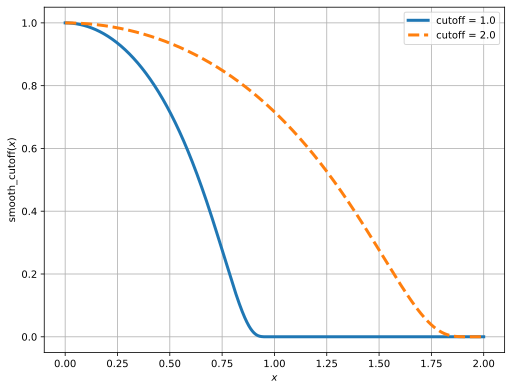

In [364]:
import numpy as np, matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as inl
import e3x
inl.set_matplotlib_formats('pdf', 'svg')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
x = np.linspace(0, 2, num=1001)
y1 = e3x.nn.smooth_cutoff(x, cutoff=1.0)
y2 = e3x.nn.smooth_cutoff(x, cutoff=2.0)
plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_cutoff}(x)$')
plt.plot(x, y1, lw=3, ls='-',  label='cutoff = 1.0')
plt.plot(x, y2, lw=3, ls='--', label='cutoff = 2.0')
plt.legend(); plt.grid()

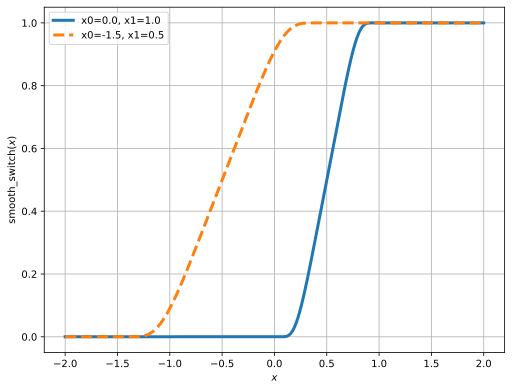

In [365]:
import numpy as np, matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as inl
from e3x.nn import smooth_switch
inl.set_matplotlib_formats('pdf', 'svg')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
x = np.linspace(-2, 2, num=1001)
y1 = smooth_switch(x, x0=0.0, x1=1.0)
y2 = smooth_switch(x, x0=-1.5, x1=0.5)
plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_switch}(x)$')
plt.plot(x, y1, lw=3, ls='-',  label='x0=0.0, x1=1.0')
plt.plot(x, y2, lw=3, ls='--', label='x0=-1.5, x1=0.5')
plt.legend(); plt.grid()

In [381]:
smooth_cutoff?

Signature:
smooth_cutoff(
    x: jaxtyping.Float[Array, '...'],
    cutoff: Union[jaxtyping.Float[Array, ''], float] = 1.0,
) -> jaxtyping.Float[Array, '...']
Docstring:
Smooth cutoff function.

Computes the function

.. math::
  \mathrm{smooth\_cutoff}(x) = \begin{cases}
    \exp\left(1-\frac{1}{1-\left(\frac{x}{c}\right)^2}\right),
    & x < c\\
    0, & x \ge c
  \end{cases}

which is zero beyond  :math:`c` = ``cutoff`` and is infinitely differentiable.

.. jupyter-execute::
  :hide-code:

  import numpy as np, matplotlib.pyplot as plt
  import matplotlib_inline.backend_inline as inl
  import e3x
  inl.set_matplotlib_formats('pdf', 'svg')
  plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
  x = np.linspace(0, 2, num=1001)
  y1 = e3x.nn.smooth_cutoff(x, cutoff=1.0)
  y2 = e3x.nn.smooth_cutoff(x, cutoff=2.0)
  plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_cutoff}(x)$')
  plt.plot(x, y1, lw=3, ls='-',  label='cutoff = 1.0')
  plt.plot(x, y2, lw=3, ls='--', label='cutoff = 2.0'

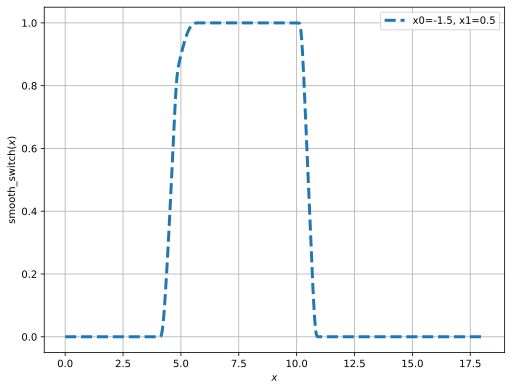

In [892]:
dif=1
MM_CUTON=5
MM_CUTOFF=1.0
BUFFER=0.001

r = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
r = jnp.linalg.norm(r, axis=1)
# print(r)

ML_CUTOFF = MM_CUTON - dif
charmm_on_scale =  smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON) #smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
charmm_off_scale = 1 - smooth_switch(r - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON) 
smoother = 1 - smooth_cutoff(r ,  cutoff=2)

# # remove any sigularities
# charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
# mm_contrib = (charmm_on_scale * mm_energy * charmm_off_scale)


plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
x = np.linspace(0, r.max(), num=1001)
y1 = smooth_switch(x, x0=ML_CUTOFF, x1=MM_CUTON)
y2 = 1 - smooth_switch(x - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON) #smooth_cutoff(10 - x ,  cutoff=10)
y3 =  1 - smooth_cutoff(x,  cutoff=6)
plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_switch}(x)$')
# plt.plot(x, y1, lw=3, ls='-',  label='x0=0.0, x1=1.0')
# plt.plot(x, y2, lw=3, ls='--', label='x0=-1.5, x1=0.5')
# plt.plot(x, y3, lw=3, ls='--', label='x0=-1.5, x1=0.5')
plt.plot(x, y1*y2*y3, lw=3, ls='--', label='x0=-1.5, x1=0.5')
# plt.plot(x, y1*y2, lw=3, ls='--', label='x0=-1.5, x1=0.5')
plt.legend(); plt.grid()
# plt.xlim(0,4)



In [2521]:
from itertools import combinations, permutations, product

R = coor.get_positions().to_numpy()

def get_MM_energy_forces_fns():


    # @jit
    def switch_MM(
        R,
        mm_energy,
        dif=10 ** (-6),
        MM_CUTON=1.5,
        MM_CUTOFF=10.0,
        BUFFER=0.001,
        debug=False,
    ):
        r = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        r = jnp.linalg.norm(r, axis=1)
        
        ML_CUTOFF = MM_CUTON - dif
        y1 = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
        y2 = 1 - smooth_switch(r - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON)
        y3 =  1 - smooth_cutoff(r,  cutoff=2)
        scale = y1*y2*y3
        # remove any sigularities
        # scale = jax.numpy.nan_to_num(scale, posinf=1)
        mm_contrib =  mm_energy * scale 
        
        return mm_contrib.sum()
    
    
    
    # # @jit
    # def switch_ML(X,
    #     ml_energy,
    #     dif=10 ** (-6),
    #     MM_CUTON=6.0,
    #     MM_CUTOFF=10.0,
    #     BUFFER=0.1,
    #     debug=False,
    # ):
    #     r = jnp.linalg.norm(X.T.mean(axis=1) - X[5:].T.mean(axis=1))
    #     ML_CUTOFF = MM_CUTON - dif
    #     ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    #     ml_contrib = ml_scale * ml_energy
    #     return ml_contrib.sum()
    
    # switch_ML_grad = jax.grad(switch_ML)
    switch_MM_grad = jax.grad(switch_MM)

    at_to_param = {"C": "CG321", "CL1": "CLGA1", "CL2": "CLGA1", "H1": "HGA2" , "H2": "HGA2" }
    
    CG321EP = -0.0560
    CG321RM = 2.0100
    CLGA1EP = -0.3430
    CLGA1RM = 1.9100
    HGA2EP =  -0.0200  
    HGA2RM = 1.3400 
       
    params =  [75, 76, 77]
    params.sort()
    at_ep = {75: CG321EP, 76:CLGA1EP , 77: HGA2EP}
    at_rm = {75: CG321RM, 76: CLGA1RM , 77: HGA2RM}
    at_q = {75: -0.018, 76: -0.081 , 77: 0.09}

    at_flat_rm = np.zeros(100)
    at_flat_rm[75] = CG321RM
    at_flat_rm[76] = CLGA1RM
    at_flat_rm[77] = HGA2RM

    at_flat_ep = np.zeros(100)
    at_flat_ep[75] = CG321EP
    at_flat_ep[76] = CLGA1EP
    at_flat_ep[77] = HGA2EP

    at_flat_q = np.zeros(100)
    at_flat_q[75] =  -0.018
    at_flat_q[76] =  -0.081
    at_flat_q[77] =  0.09

    pair_idxs_product = jnp.array([(a,b) for a,b in list(product(np.arange(5), repeat=2))])
    dimer_perms = jnp.array(dimer_permutations(20))
    
    pair_idxs_np = dimer_perms * 5
    pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
    pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
    displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]


    at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]

    charges = np.array(psf.get_charges())
    masses = np.array(psf.get_amass())
    at_codes = np.array(psf.get_iac())
    atomtype_codes = np.array(psf.get_atype())
    
    at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
    at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
    at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]
    at_perms_ep, at_perms_rm

    rmins_per_system = jnp.take(at_flat_rm, at_codes) #jnp.array([ NBL["pair_rm"][k] for k in atom_keys ])
    epsilons_per_system = jnp.take(at_flat_ep, at_codes) #jnp.array([ NBL["pair_ep"][k] for k in atom_keys ])

    rs = distances
    q_per_system = jnp.take(at_flat_q, at_codes)


    q_a = jnp.take(q_per_system, pair_idx_atom_atom[:, 0])
    q_b = jnp.take(q_per_system, pair_idx_atom_atom[:, 1])
    
    rm_a = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 0])
    rm_b = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 1])
    
    ep_a = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 0])
    ep_b = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 1])

    pair_qq = q_a * q_b
    pair_rm = (rm_a + rm_b)
    pair_ep = (ep_a * ep_b)**0.5
    
    def LJ(r, sig, ep):
        """
        rmin = 2^(1/6) * sigma
            https://de.wikipedia.org/wiki/Lennard-Jones-Potential
        Lennard-Jones potential for a pair of atoms
        """
        a = 6
        b = 2
        # sig = sig / (2 ** (1 / 6))
        r6 = (sig / r) ** a
        return ep * (r6 ** b - 2 * r6)
    
    coloumns_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
    def Coloumb(r, qq, constant = coloumns_constant):
        return constant * qq/r
    
    # Coloumb_grad = jax.grad(LJ, argnums=1)
    # LJ_grad = jax.grad(LJ, argnums=2)
    
    def MM_energy(R):
        displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements, axis=1)
        mask = (pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])

        lj_energies = LJ(distances, pair_rm, pair_ep) * mask
        vdw = lj_energies.sum()
        
        ele_energies = Coloumb(distances, pair_qq) * mask    
        ele = ele_energies.sum()
              
        return vdw + ele

    def MM_eneries(R):
        displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements)
        mask = (pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])
        
        lj_energies = LJ(distances, pair_rm, pair_ep) * mask
        vdw = lj_energies
        
        ele_energies = Coloumb(distances, pair_qq) * mask    
        ele = ele_energies 
              
        return vdw + ele
    
    MM_grad = jax.grad(MM_energy)

    def MM_energy_and_grad(R):
        mm_energy = MM_energy(R)
        mm_energies = MM_eneries(R)
        s_mm_energy = switch_MM(R, mm_energies)
        mm_grad = MM_grad(R)
        grad_mm_s = switch_MM_grad(R, mm_energies)  # MM switching gradient
        mm_grad = mm_grad + grad_mm_s 

        return s_mm_energy, mm_grad

    return MM_energy_and_grad

In [2522]:
energy.show()
energy.get_elec() , energy.get_vdw()

(-1.6167886603225763, -40.61333746711849)

In [2523]:
MM_energy_and_gradient = get_MM_energy_forces_fns()

In [2524]:
mm_e, mm_f = MM_energy_and_gradient(R)

In [2525]:
mm_e

Array gpu:0 -0.007

In [2526]:
mm_f

Array[100, 3] n=300 (1.2Kb) x∈[-21.705, 19.105] μ=3.179e-08 σ=2.464 gpu:0

In [2527]:
np.array(mm_f)

array([[ 1.01508677e-01,  2.01789618e-01, -4.03493613e-01],
       [ 1.61584866e+00, -3.63030910e-01,  9.96505320e-01],
       [-4.47692759e-02,  1.75615981e-01,  2.01214314e-01],
       [ 2.19385758e-01, -2.87260264e-02,  2.76133865e-02],
       [ 1.79005176e-01,  1.79747380e-02, -1.07023680e+00],
       [-2.09562421e-01, -2.46844754e-01, -2.23394245e-01],
       [ 2.37414527e+00, -9.93785203e-01, -5.71332335e-01],
       [-5.16835392e-01,  1.23803020e-01, -7.73158789e-01],
       [ 2.25200817e-01, -2.36131281e-01,  5.56433164e-02],
       [-2.84082890e-02, -4.83285114e-02,  1.84463575e-01],
       [ 1.72824144e-01,  2.34609962e-01, -4.29212749e-01],
       [ 1.05011916e+00, -9.39979076e-01,  2.80076170e+00],
       [-2.09872842e+00, -7.21729398e-01, -8.96130085e-01],
       [ 3.92121553e+00,  2.86948705e+00,  3.19965816e+00],
       [-6.16062737e+00,  1.71899261e+01, -1.97524223e+01],
       [-1.34807497e-01,  3.83275867e-01,  1.82499558e-01],
       [ 2.05747873e-01,  2.38894299e-01

In [2528]:
MM_energy(R) ,  ( energy.get_elec() + energy.get_vdw())

(Array gpu:0 -46.757, -42.23012612744107)

In [887]:
MM_grad(R)

Array[100, 3] n=300 (1.2Kb) x∈[-4.316, 5.741] μ=-7.153e-09 σ=0.877 gpu:0

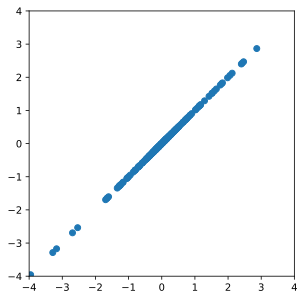

In [888]:
plt.scatter(jnp.array(coor.get_forces()).flatten(), mm_f.flatten())
plt.xlim(-4, 4)
plt.ylim(-4,4)
plt.gca().set_aspect("equal")

In [204]:
mask.sum(), mask.shape

(4750, (4750,))

(array([110., 541., 768., 886., 823., 744., 476., 262., 118.,  22.]),
 array([ 2.1794921 ,  3.76968999,  5.35988788,  6.95008577,  8.54028366,
        10.13048155, 11.72067944, 13.31087733, 14.90107522, 16.49127311,
        18.081471  ]),
 <BarContainer object of 10 artists>)

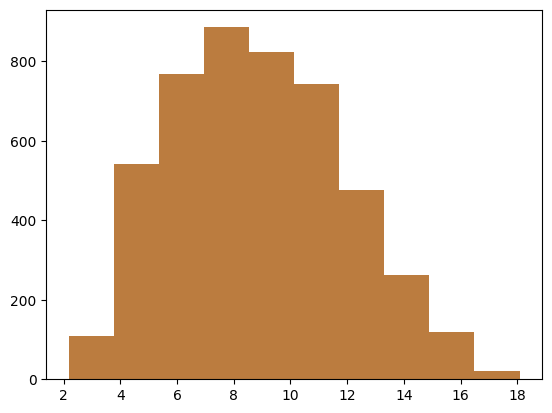

In [205]:
import matplotlib.pyplot as plt
plt.hist(distances)
NBL = capture_neighbour_list()
plt.hist(NBL["pair_distance_dict"].values(), alpha=0.7)

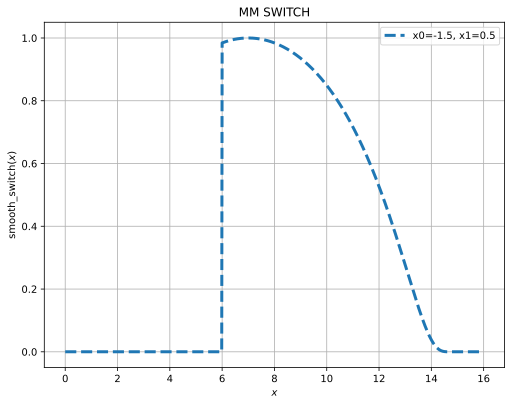

In [2229]:
dif=0.0001
MM_CUTON=6
MM_CUTOFF=100.5
ML_CUTOFF = MM_CUTON - dif
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
x = np.linspace(0, 16, num=1001)
y1 = smooth_switch(x, x0=ML_CUTOFF, x1=MM_CUTON)
y2 = 1 # - smooth_switch(x - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON) #smooth_cutoff(10 - x ,  cutoff=10)
y3 =   smooth_cutoff(x - 7,  cutoff=8)
plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_switch}(x)$')
plt.title("MM SWITCH")
plt.plot(x, y1*y2*y3, lw=3, ls='--', label='x0=-1.5, x1=0.5')
plt.legend(); plt.grid()
plt.show()

# Full python

In [2781]:
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
) 

from itertools import combinations, permutations, product

R = coor.get_positions().to_numpy()

def get_MM_energy_forces_fns(energy_or_forces="energy"):

    # @jit
    def switch_MM(
        R,
        mm_energy,
        dif=1,
        MM_CUTON=6,
        MM_CUTOFF=8,
        debug=False,
    ):
        r = R[pair_idx_atom_atom[:,0]].mean(axis=-1)  - R[pair_idx_atom_atom[:,1]].mean(axis=-1) 
        r = jnp.linalg.norm(r)
        
        ML_CUTOFF = MM_CUTON - dif
        y1 = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
        y2 = 1 #- #smooth_switch(r - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON)
        y3 =   smooth_cutoff(r - 7,  cutoff=MM_CUTOFF)
        scale = y1*y3
        # remove any sigularities
        # scale = jax.numpy.nan_to_num(scale, posinf=1)
        mm_contrib =  mm_energy * scale 
        
        return mm_contrib.sum()


    dif=0.0001
    MM_CUTON=7
    MM_CUTOFF=10.5
    BUFFER=0.1
        
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    x = np.linspace(0, 16, num=1001)
    y1 = smooth_switch(x, x0=ML_CUTOFF, x1=MM_CUTON)
    y2 = 1 #- smooth_switch(x - MM_CUTOFF - MM_CUTON, x0=ML_CUTOFF, x1=MM_CUTON) #smooth_cutoff(10 - x ,  cutoff=10)
    y3 =   smooth_cutoff(x - 7,  cutoff=8)
    plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_switch}(x)$')
    plt.title("MM SWITCH")
    plt.plot(x, y1*y2*y3, lw=3, ls='--', label='x0=-1.5, x1=0.5')
    plt.legend(); plt.grid()
    plt.show()
    
    
    
    # # @jit
    # def switch_ML(X,
    #     ml_energy,
    #     dif=10 ** (-6),
    #     MM_CUTON=6.0,
    #     MM_CUTOFF=10.0,
    #     BUFFER=0.1,
    #     debug=False,
    # ):
    #     r = jnp.linalg.norm(X.T.mean(axis=1) - X[5:].T.mean(axis=1))
    #     ML_CUTOFF = MM_CUTON - dif
    #     ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    #     ml_contrib = ml_scale * ml_energy
    #     return ml_contrib.sum()
    
    # switch_ML_grad = jax.grad(switch_ML)
    switch_MM_grad = jax.grad(switch_MM)

    at_to_param = {"C": "CG321", "CL1": "CLGA1", "CL2": "CLGA1", "H1": "HGA2" , "H2": "HGA2" }
    
    CG321EP = -0.0560
    CG321RM = 2.0100
    CLGA1EP = -0.3430
    CLGA1RM = 1.9100
    HGA2EP =  -0.0200  
    HGA2RM = 1.3400 
       
    params =  [75, 76, 77]
    params.sort()
    at_ep = {75: CG321EP, 76:CLGA1EP , 77: HGA2EP}
    at_rm = {75: CG321RM, 76: CLGA1RM , 77: HGA2RM}
    at_q = {75: -0.018, 76: -0.081 , 77: 0.09}

    at_flat_rm = np.zeros(100)
    at_flat_rm[75] = CG321RM
    at_flat_rm[76] = CLGA1RM
    at_flat_rm[77] = HGA2RM

    at_flat_ep = np.zeros(100)
    at_flat_ep[75] = CG321EP
    at_flat_ep[76] = CLGA1EP
    at_flat_ep[77] = HGA2EP

    at_flat_q = np.zeros(100)
    at_flat_q[75] =  -0.018
    at_flat_q[76] =  -0.081
    at_flat_q[77] =  0.09

    pair_idxs_product = jnp.array([(a,b) for a,b in list(product(np.arange(5), repeat=2))])
    dimer_perms = jnp.array(dimer_permutations(20))
    
    pair_idxs_np = dimer_perms * 5
    pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
    pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
    displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]


    at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]

    charges = np.array(psf.get_charges())
    masses = np.array(psf.get_amass())
    at_codes = np.array(psf.get_iac())
    atomtype_codes = np.array(psf.get_atype())
    
    at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
    at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
    at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]
    at_perms_ep, at_perms_rm

    rmins_per_system = jnp.take(at_flat_rm, at_codes) #jnp.array([ NBL["pair_rm"][k] for k in atom_keys ])
    epsilons_per_system = jnp.take(at_flat_ep, at_codes) #jnp.array([ NBL["pair_ep"][k] for k in atom_keys ])

    rs = distances
    q_per_system = jnp.take(at_flat_q, at_codes)


    q_a = jnp.take(q_per_system, pair_idx_atom_atom[:, 0])
    q_b = jnp.take(q_per_system, pair_idx_atom_atom[:, 1])
    
    rm_a = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 0])
    rm_b = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 1])
    
    ep_a = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 0])
    ep_b = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 1])

    pair_qq = q_a * q_b
    pair_rm = (rm_a + rm_b)
    pair_ep = (ep_a * ep_b)**0.5
    
    def LJ(r, sig, ep):
        """
        rmin = 2^(1/6) * sigma
            https://de.wikipedia.org/wiki/Lennard-Jones-Potential
        Lennard-Jones potential for a pair of atoms
        """
        a = 6
        b = 2
        # sig = sig / (2 ** (1 / 6))
        r6 = (sig / r) ** a
        return ep * (r6 ** b - 2 * r6)
    
    coloumns_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
    def Coloumb(r, qq, constant = coloumns_constant):
        return constant * qq/r
    
    # Coloumb_grad = jax.grad(LJ, argnums=1)
    # LJ_grad = jax.grad(LJ, argnums=2)
    
    def MM_energy(R):
        displacements = R[pair_idx_atom_atom[:,0]]  - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements, axis=1)
        mask = (pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])

        lj_energies = LJ(distances, pair_rm, pair_ep) * mask
        vdw = lj_energies.sum()
        
        ele_energies = Coloumb(distances, pair_qq) * mask    
        ele = ele_energies.sum()
              
        return vdw + ele

    def MM_eneries(R):
        displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements, axis=1)
        
        mask = (pair_idx_atom_atom[:, 0] <  pair_idx_atom_atom[:, 1])
        
        lj_energies = LJ(distances, pair_rm, pair_ep) * mask
        vdw = lj_energies
        
        ele_energies = Coloumb(distances, pair_qq) * mask    
        ele = ele_energies 
              
        return vdw + ele
    
    MM_grad = jax.grad(MM_energy)

    def MM_energy_and_grad(R):
        mm_energy = MM_energy(R)
        mm_energies = MM_eneries(R)
        mm_energies = jax.numpy.nan_to_num(mm_energies, posinf=0)
        s_mm_energy = switch_MM(R, mm_energies)
        mm_grad = MM_grad(R)
        grad_mm_s = switch_MM_grad(R, mm_energies)  # MM switching gradient
        # mm_grad = s_mm_energy * mm_grad + mm_energy * grad_mm_s 

        return s_mm_energy, mm_grad + grad_mm_s

    return MM_energy_and_grad


def prepare_batches_md(
    data,
    batch_size: int,
    data_keys = None,
    num_atoms: int = 60,
    dst_idx = None,
    src_idx= None,
    include_id: bool = False,
    debug_mode: bool = False,
) :
    """
    Efficiently prepare batches for training.

    Args:
        key: JAX random key for shuffling.
        data (dict): Dictionary containing the dataset.
            Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
        batch_size (int): Size of each batch.
        data_keys (list, optional): List of keys to include in the output.
            If None, all keys in `data` are included.
        num_atoms (int, optional): Number of atoms per example. Default is 60.
        dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
        src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
        include_id (bool, optional): Whether to include 'id' key if present in data.
        debug_mode (bool, optional): If True, run assertions and extra checks.

    Returns:
        list: A list of dictionaries, each representing a batch.
    """

    # -------------------------------------------------------------------------
    # Validation and Setup
    # -------------------------------------------------------------------------

    # Check for mandatory keys
    required_keys = ["R", "N", "Z"]
    for req_key in required_keys:
        if req_key not in data:
            raise ValueError(f"Data dictionary must contain '{req_key}' key.")

    # Default to all keys in data if none provided
    if data_keys is None:
        data_keys = list(data.keys())

    # Verify data sizes
    data_size = len(data["R"])
    steps_per_epoch = data_size // batch_size
    if steps_per_epoch == 0:
        raise ValueError(
            "Batch size is larger than the dataset size or no full batch available."
        )

    # -------------------------------------------------------------------------
    # Compute Random Permutation for Batches
    # -------------------------------------------------------------------------
    # perms = jax.random.permutation(key, data_size)
    perms = jnp.arange(0, data_size)
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    # -------------------------------------------------------------------------
    # Precompute Batch Segments and Indices
    # -------------------------------------------------------------------------
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    offsets = jnp.arange(batch_size) * num_atoms

    # Compute pairwise indices only if not provided
    # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
    if dst_idx is None or src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

    # Adjust indices for batching
    dst_idx = dst_idx + offsets[:, None]
    src_idx = src_idx + offsets[:, None]

    # Centralize reshape logic
    # For keys not listed here, we default to their original shape after indexing.
    reshape_rules = {
        "R": (batch_size * num_atoms, 3),
        "F": (batch_size * num_atoms, 3),
        "E": (batch_size, 1),
        "Z": (batch_size * num_atoms,),
        "D": (batch_size,3),
        "N": (batch_size,),
        "mono": (batch_size * num_atoms,),
    }

    output = []

    # -------------------------------------------------------------------------
    # Batch Preparation Loop
    # -------------------------------------------------------------------------
    for perm in perms:
        # Build the batch dictionary
        batch = {}
        for k in data_keys:
            if k not in data:
                continue
            v = data[k][jnp.array(perm)]
            new_shape = reshape_rules.get(k, None)
            if new_shape is not None:
                batch[k] = v.reshape(new_shape)
            else:
                batch[k] = v

        # Optionally include 'id' if requested and present
        if include_id and "id" in data and "id" in data_keys:
            batch["id"] = data["id"][jnp.array(perm)]

        # Compute good_indices (mask for valid atom pairs)
        # Vectorized approach: We know N is shape (batch_size,)
        # Expand N to compare with dst_idx/src_idx
        # dst_idx[i], src_idx[i] range over atom pairs within the ith example
        # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
        # We'll compute this for all i and concatenate.
        N = batch["N"]
        # Expand N and offsets for comparison
        expanded_n = N[:, None] + offsets[:, None]
        valid_dst = dst_idx < expanded_n
        valid_src = src_idx < expanded_n
        good_pairs = (valid_dst & valid_src).astype(jnp.int32)
        good_indices = good_pairs.reshape(-1)

        # Add metadata to the batch
        atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
        batch.update(
            {
                "dst_idx": dst_idx.flatten(),
                "src_idx": src_idx.flatten(),
                "batch_mask": good_indices,
                "batch_segments": batch_segments,
                "atom_mask": atom_mask,
            }
        )

        # Debug checks
        if debug_mode:
            # Check expected shapes
            assert batch["R"].shape == (
                batch_size * num_atoms,
                3,
            ), f"R shape mismatch: {batch['R'].shape}"
            assert batch["F"].shape == (
                batch_size * num_atoms,
                3,
            ), f"F shape mismatch: {batch['F'].shape}"
            assert batch["E"].shape == (
                batch_size,
                1,
            ), f"E shape mismatch: {batch['E'].shape}"
            assert batch["Z"].shape == (
                batch_size * num_atoms,
            ), f"Z shape mismatch: {batch['Z'].shape}"
            assert batch["N"].shape == (
                batch_size,
            ), f"N shape mismatch: {batch['N'].shape}"
            # Optional: print or log if needed

        output.append(batch)

    return output



# switch_MM_grad = jax.grad(switch_MM)


def get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,
   
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    energy_or_forces="energy"
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """       
    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
    from physnetjax.data.batches import prepare_batches_jit
    N_MONOMERS = 20
    restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1")
    
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)
    
    # Setup monomer model
    params, MODEL = get_params_model(restart)
    MODEL.natoms = 10

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(20)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)


    @jit
    def switch_ML(R,
        ml_energy,
        dif=1,
        MM_CUTON=6.0,
        MM_CUTOFF=10.5,
        BUFFER=0.1,
        debug=False,
    ):
        _ = R
        r = jnp.linalg.norm(_[:5].T.mean(axis=1) - _[5:10].T.mean(axis=1))
        ML_CUTOFF = MM_CUTON - dif
        ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
        ml_contrib = ml_scale * ml_energy
        return ml_contrib.sum()
    
    switch_ML_grad = jax.grad(switch_ML)

    dif= 1
    MM_CUTON=8
    MM_CUTOFF=10.5
    BUFFER=0.1
    ML_CUTOFF = MM_CUTON - dif    
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    x = np.linspace(0, 16, num=1001)
    y1 = 1 - abs(smooth_switch(x, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    plt.xlabel(r'$x$'); plt.ylabel(r'$\mathrm{smooth\_switch}(x)$')
    plt.title("ML SWITCH")
    plt.plot(x, y1, lw=3, ls='--', label='x0=-1.5, x1=0.5')
    plt.legend(); plt.grid()
    plt.show()
    
    def get_energy_fn(Z, R):
    
        data = {"R": [], "Z":[], "N": []}
        
        # Prepare monomer data
        x_positions = jnp.zeros((len(all_monomer_idxs), 10, 3))
        x_positions = x_positions.at[:, :5].set(R[jnp.array(all_monomer_idxs)])
        
        x_atomic = jnp.zeros((len(all_monomer_idxs), 10), dtype=jnp.int32)
        x_atomic = x_atomic.at[:, :5].set(Z[jnp.array(all_monomer_idxs)])
        
        # Prepare dimer data
        dimer_positions = jnp.zeros((len(all_dimer_idxs), 10, 3))
        dimer_positions = dimer_positions.at[:].set(R[jnp.array(all_dimer_idxs)])
        
        dimer_atomic = jnp.zeros((len(all_dimer_idxs), 10), dtype=jnp.int32)
        dimer_atomic = dimer_atomic.at[:].set(Z[jnp.array(all_dimer_idxs)])
        
        # Combine monomer and dimer data
        data["R"] = jnp.concatenate([x_positions, dimer_positions])
        data["Z"] = jnp.concatenate([x_atomic, dimer_atomic])
        data["N"] = jnp.concatenate([
            jnp.full((len(all_monomer_idxs),), 5),
            jnp.full((len(all_dimer_idxs),), 10)
        ])
        
        batches = prepare_batches_md(data, 200, num_atoms=10)[0]
        MODEL.charges = True
        
        @jax.jit
        def apply_model(atomic_numbers, positions):
            return MODEL.apply(
                params,
                atomic_numbers=atomic_numbers,
                positions=positions,
                dst_idx=batches["dst_idx"],
                src_idx=batches["src_idx"],
                batch_segments = batches["batch_segments"],
                batch_size = 200,
                batch_mask = batches["batch_mask"],
                atom_mask = batches["atom_mask"]
            )
    
        return apply_model, batches 
        
    def calc_dimer_energy_forces(R, Z, i, ml_e, ml_f):
        a,b = dimer_perms[i]
        a,b = all_monomer_idxs[a], all_monomer_idxs[b]
        idxs = np.array([a, b], dtype=int).flatten()
        _R = R[idxs]
        final_energy = ml_e
        val_ml_s = switch_ML(_R, final_energy)  # ML switching value
        grad_ml_s = switch_ML_grad(_R, final_energy)  # ML switching gradient
        # Combine forces with switching functions
        ml_forces_out =  ml_f + grad_ml_s 

        outdict = {
            "energy": val_ml_s,
            "forces": ml_forces_out,
        }
        return outdict

    MM_energy_and_gradient = get_MM_energy_forces_fns()

    
    @jit
    def spherical_cutoff_calculator(R, Z, forces=True):
        output_ = []

        apply_model, batches = get_energy_fn(Z, R)
        
        output = apply_model(batches["Z"], batches["R"])
        
        f = output["forces"] / (ase.units.kcal/ase.units.mol)
        e = output["energy"] / (ase.units.kcal/ase.units.mol)

        ml_monomer_forces = f[:200]
        # print(ml_monomer_forces)
        # print(np.array(ml_monomer_forces))
        dimer_forces = f[200:]
        print(dimer_forces.shape)
        
        monomer_energy = jnp.array(e[:20])
        dimer_energy = jnp.array(e[20:])
        
        for i, idx in enumerate(all_dimer_idxs):
            # ml_f = monomer_forces[all_dimer_idxs[i]] - dimer_forces[all_dimer_idxs[i]]
            # ml_e = monomer_energy[all_dimer_idxs[i]] - dimer_energy[all_dimer_idxs[i]]
            a,b = dimer_perms[i]

            a_1, b_1 = all_monomer_idxs[a], all_monomer_idxs[b]
            # print(a, b)
            a_ = 10 * a + jnp.arange(5, dtype=jnp.int32)
            b_ = 10 * b + jnp.arange(5, dtype=jnp.int32)
            # print(a_, b_)
            # print(a_1, b_1)
            ml_f = jnp.concatenate([
                ml_monomer_forces[a_][None,...], 
                ml_monomer_forces[b_][None, ...]
            ], axis=0).reshape(10,3)
            
            # _tmp_R = jnp.concatenate([R[a_1][None,...], R[b_1][None, ...]], axis=0).reshape(10,3)
            ml_f = dimer_forces[i] - ml_f
            
            ml_e =  dimer_energy[i] - (monomer_energy[a] + monomer_energy[b]) 
            output_.append(calc_dimer_energy_forces(R, Z, i, ml_e, ml_f))
            
        out_E = 0
        out_F = jnp.zeros((100, 3))
        
        for i, _ in enumerate(output_):
            out_E += output_[i]["energy"]
            # Reshape forces to match expected dimensions
            forces = output_[i]["forces"].reshape(-1, 3)  # Ensure forces are (N, 3)
            out_F = out_F.at[all_dimer_idxs[i]].add(forces)
        
        out_F = jnp.array(out_F)

        mm_E, mm_grad = MM_energy_and_gradient(R)

        out_E += mm_E
        out_F += mm_grad

        out_E += monomer_energy.sum() 
        segtest = np.array([  5 * a + np.array([np.arange(5, dtype=int), np.ones(5)*-1000], dtype=int).flatten() for a in range(20)]).flatten()

        
        out_F += jax.ops.segment_sum(ml_monomer_forces, 
                                    segtest,
                                    num_segments=100)

        # print(mm_grad)
        # print(out_F)
        # print()
        # return out_E.sum()
        return {"energy": out_E.sum(), "forces": out_F}

    # spherical_cutoff_calculator_grad = jax.grad(spherical_cutoff_calculator)

    @jit
    def energy_fn(position, **kwargs):
      l_nbrs = nbrs.update(position)
      return spherical_cutoff_calculator(position, atomic_numbers)[energy_or_forces]

    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            # tmp_coord = coor.get_positions().to_numpy() * 0
            # tmp_coord[:len(R), :] = R   
            # set_pycharmm_xyz(tmp_coord)
            _ = spherical_cutoff_calculator(R, Z)
            # forces = spherical_cutoff_calculator_grad(R, Z)
            self.results["energy"] = _["energy"] * (ase.units.kcal/ase.units.mol)
            self.results["forces"] =  _["forces"] * (ase.units.kcal/ase.units.mol)


    return AseDimerCalculator(), energy_fn

In [2782]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "



read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       -0.0200    1.3400 ! alkane, yin and mackerell, 4/98
END



/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19


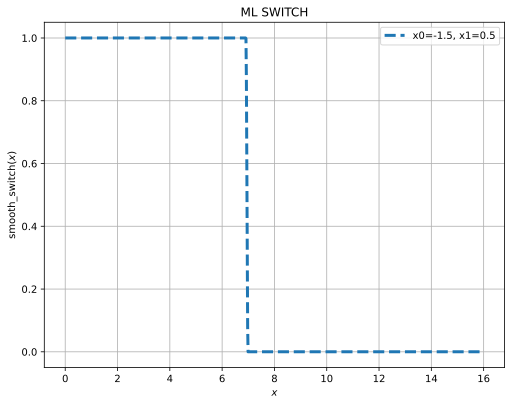

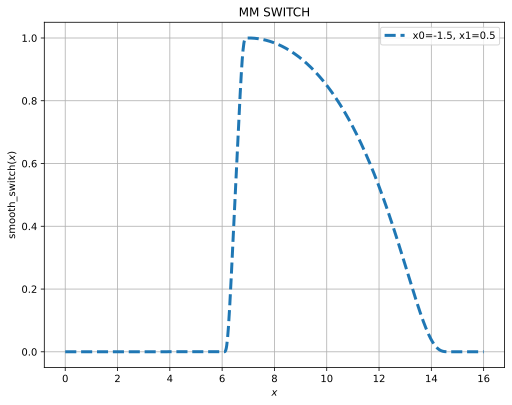

In [2783]:
calculator, jax_md_energy_fn = get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,    
    "forces"
)

In [2784]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions - atom_positions.T.mean())
ase_atoms_with_calc.calc = calculator

(1800, 3)


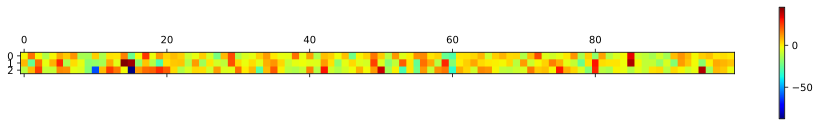

In [2785]:
f = jnp.array(ase_atoms_with_calc.get_forces()).T
plt.matshow(f)
ase_atoms_with_calc.get_potential_energy()
plt.colorbar()


             eps         max(abs(df))
  0.100000000000 Array gpu:0 190.748
  0.010000000000 Array gpu:0 89.994
  0.001000000000 Array gpu:0 89.890
  0.000100000000 Array gpu:0 92.194
  0.000010000000 Array gpu:0 250.712
  0.000001000000 Array gpu:0 2.591e+03
  0.000000100000 Array gpu:0 1.588e+04
  0.000000010000 Array gpu:0 1.404e+05
      Step     Time          Energy          fmax
BFGS:    0 07:09:50     -335.499268       99.498439
BFGS:    1 07:09:50     -152.229813   568616.254316
BFGS:    2 07:09:50    -9224.722656  3586305.891355
BFGS:    3 07:09:50   -11444.087891  3808829.358291
BFGS:    4 07:09:50     1844.368164  3032298.463073
BFGS:    5 07:09:50    18510.861328  3796348.493474
BFGS:    6 07:09:50    -2193.014160 28189398.105150
BFGS:    7 07:09:50     -570.453430 17463995.264996
BFGS:    8 07:09:50     4665.790527 63479202.768053
BFGS:    9 07:09:50   -10134.772461  8511731.923358
BFGS:   10 07:09:50    15092.535156 10968904.840891
BFGS:   11 07:09:50     2766.414307  5575

<Figure size 640x480 with 0 Axes>

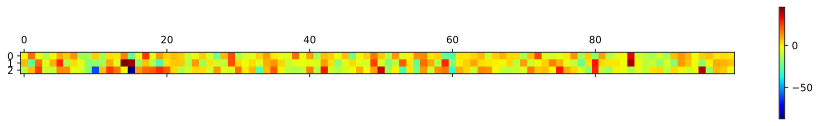

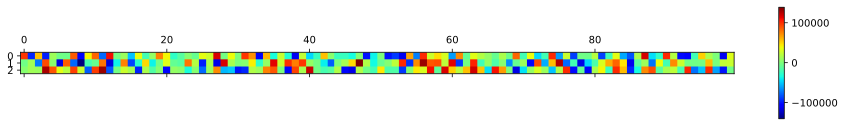

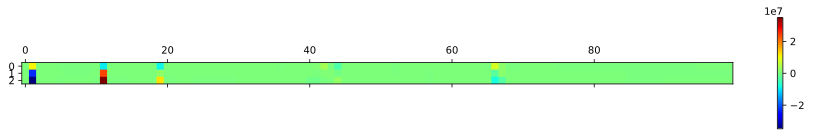

In [2786]:
plt.set_cmap('jet')
from ase.calculators.test import gradient_test
f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,100,1))
plt.matshow(np.array(ase_atoms_with_calc.get_forces()).T)
plt.colorbar()
plt.matshow((f - jnp.array(fn)).T)
plt.colorbar()
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.01,steps=100)
plt.matshow(np.array(ase_atoms_with_calc.get_forces()).T)
plt.colorbar()




In [2780]:
view_atoms(ase_atoms_with_calc)

In [2613]:
f, jnp.array(fn)

(Array[100, 3] n=300 (1.2Kb) x∈[-2.449, 4.891] μ=0.001 σ=0.794 gpu:0,
 Array[100, 3] n=300 (1.2Kb) x∈[-1.511e+05, 1.602e+05] μ=244.141 σ=6.816e+04 gpu:0)

In [2614]:
view_atoms(ase_atoms_with_calc)

In [2615]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [2607]:
# Parameters.
temperature = 298.0
timestep_fs = 0.05
num_steps = 5 * 20_000


atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 10 == 0:
      MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
      # Stationary(atoms)  # Remove center of mass translation.
      # ZeroRotation(atoms)  # Remove rotations.
  if i % 1000 == 0:
      print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -338.168 ekin  4.187 etot -333.981
step  1000 epot -336.599 ekin  3.693 etot -332.905
step  2000 epot -330.783 ekin  4.138 etot -326.645
step  3000 epot -338.072 ekin  3.961 etot -334.111
step  4000 epot -336.361 ekin  3.836 etot -332.525
step  5000 epot -328.947 ekin  3.914 etot -325.033
step  6000 epot -328.711 ekin  3.757 etot -324.954
step  7000 epot -320.295 ekin  3.419 etot -316.875
step  8000 epot -320.538 ekin  3.915 etot -316.623
step  9000 epot -320.533 ekin  3.833 etot -316.700
step 10000 epot -320.658 ekin  3.565 etot -317.093
step 11000 epot -319.880 ekin  3.709 etot -316.171
step 12000 epot -466.319 ekin  87.536 etot -378.783
step 13000 epot -143.547 ekin  3.485 etot -140.062
step 14000 epot  976.129 ekin  4.215 etot  980.344
step 15000 epot  2622.974 ekin  3.931 etot  2626.905
step 16000 epot  2361.882 ekin  4.157 etot  2366.039
step 17000 epot -172.258 ekin  3.780 etot -168.478
step 18000 epot  2528.953 ekin  3.873 etot  2532.825
step 19000 epot -833.894

KeyboardInterrupt: 

In [2608]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2609]:
view3d.getModel().setCoordinates(frames[::1000], 'array')
view3d.animate({'loop': None, 'interval': 0.1})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

In [ ]:
plt.hist(total_energy - total_energy.mean())

In [2365]:
from jax_md import space
BOXSIZE = 30
displacement, shift = space.periodic(BOXSIZE)

In [2366]:
displacement(R[0], R[0])

Array[3] all_zeros gpu:0 [0., 0., 0.]

In [2367]:
from jax import vmap
vmap(displacement)(Rs[0], Rs[1]).shape

NameError: name 'Rs' is not defined

In [2368]:
from jax_md import partition

CUTOFF = BOXSIZE/2
neighbor_fn = partition.neighbor_list(displacement, BOXSIZE, CUTOFF, format=partition.Sparse)

In [2369]:
nbrs = neighbor_fn.allocate(R)

In [2370]:
nbrs.idx.shape

(2, 9900)

In [2371]:
# ! pip install google
# from jax_md.colab_tools import renderer
import jax.numpy as jnp

red = jnp.array([1.0, 0.2, 0.2])
blue = jnp.array([0.2, 0.2, 1.0])

from jax import jit

# @jit
# def energy_fn(position, **kwargs):
#   l_nbrs = nbrs.update(position)
#   ase_atoms_with_calc.set_positions(position)
#   return ase_atoms_with_calc.get_potential_energy()

# pred_Es = vmap(energy_fn)(R)

# plt.plot(pred_Es, test_Es, 'o')



jax_md_grad_fn = jax.grad(jax_md_energy_fn)

jax_md_energy_fn(R)

NameError: name 'energy_or_forces' is not defined

In [2358]:
jax_md_grad_fn(R)

Array[100, 3] n=300 (1.2Kb) x∈[-1.464e+06, 1.693e+06] μ=-7.918e+03 σ=2.406e+05 NaN! gpu:0

In [2326]:
from jax_md import minimize

init_fn, step_fn = minimize.fire_descent(jax_md_energy_fn, shift)

In [2327]:
# from jax_md import minimize

# init_fn, step_fn = minimize.fire_descent(energy_fn, shift)

In [2328]:
state = init_fn(R)

positions = []

for i in range(1):
  print(i)
  positions += [state.position]
  state = jit(step_fn)(state)

0


In [2334]:
np.array(state.position)

array([[        nan,         nan,         nan],
       [23.623753  , 26.29155   , 10.011919  ],
       [22.439337  , 28.53412   , 11.114217  ],
       [        nan,         nan,         nan],
       [23.187048  , 28.399153  ,  8.783441  ],
       [        nan,         nan,         nan],
       [13.873625  , 12.809267  , 17.872007  ],
       [        nan,         nan,         nan],
       [28.679504  , 15.903477  , 21.913414  ],
       [12.278113  ,  1.1381798 , 13.522461  ],
       [ 3.8085501 , 26.72924   ,  7.0761876 ],
       [22.999872  , 27.5288    ,  8.948432  ],
       [23.966242  , 23.319174  ,  0.42766833],
       [24.581503  , 29.093838  ,  2.6739438 ],
       [27.621227  , 25.825481  ,  8.805753  ],
       [27.345602  ,  3.2910204 ,  1.3719876 ],
       [        nan,         nan,         nan],
       [27.276173  ,  1.391851  ,  4.479562  ],
       [25.26969   ,  0.28059375,  6.3729234 ],
       [ 0.10818577, 29.712088  ,  3.6659403 ],
       [ 3.15625   , 19.940674  , 11.287

In [2325]:
state

FireDescentState(position=Array[100, 3] n=300 (1.2Kb) NaN! gpu:0, momentum=Array[100, 3] n=300 (1.2Kb) NaN! gpu:0, force=Array[100, 3] n=300 (1.2Kb) NaN! gpu:0, mass=Array gpu:0 1.000, dt=Array f16 gpu:0 0.100, alpha=Array f16 gpu:0 0.100, n_pos=Array i32 gpu:0 0)

# Validation with "stealing" charmms neighbour list

In [81]:
NBL = capture_neighbour_list()

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2RM = 1.3400 

set_param_card(    
    CG321EP=CG321EP,
    CG321RM=CG321RM,
    CLGA1EP=CLGA1EP,
    CLGA1RM=CLGA1RM,
    HGA2EP=HGA2EP,
    HGA2RM=HGA2RM,)

at_to_param = {"C": "CG321", "CL1": "CLGA1", "CL2": "CLGA1", "H1": "HGA2" , "H2": "HGA2" }

params =  ["CG321", "CLGA1", "HGA2"]
params.sort()
at_ep = {"CG321": CG321EP, "CLGA1":CLGA1EP , "HGA2": HGA2EP}
at_rm = {"CG321": CG321RM, "CLGA1":CLGA1RM , "HGA2": HGA2RM}
at_q = {"CG321": -0.018, "CLGA1": -0.081 , "HGA2": 0.09}

charges = psf.get_charges()
masses = psf.get_amass()
at_codes = psf.get_iac()

at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]
at_perms_ep, at_perms_rm

NBL["pair_at_dict"] = {}
NBL["pair_at_idx_dict"] = {}
NBL["pair_ep"] = {}
NBL["pair_rm"] = {}
NBL["pair_valid"] = {}
NBL["pair_qq"] = {}

for k in NBL["pair_distance_dict"]:
    a,b = k
    atom_a, atom_b = NBL["atom_number_type_dict"][a], NBL["atom_number_type_dict"][b]
    atom_a, atom_b = at_to_param[atom_a], at_to_param[atom_b]
    valid_keys = None
    if (atom_a, atom_b) in at_perms:
        valid_keys = (atom_a, atom_b)
    elif (atom_b, atom_a) in at_perms:
        valid_keys = (atom_b, atom_a) 
    else:
        print(atom_a, atom_b)
        raise Exception()
        
    NBL["pair_at_dict"][k] = valid_keys
    at_index = at_perms.index(valid_keys)
    NBL["pair_at_idx_dict"][k] = at_index
    NBL["pair_ep"][k] = at_perms_ep[at_index]
    NBL["pair_rm"][k] = at_perms_rm[at_index]
    NBL["pair_qq"][k] = at_perms_qq[at_index]
    NBL["pair_valid"][k] = NBL["pair_resid_dict"][k][0] !=  NBL["pair_resid_dict"][k][1]

def LJ(sig, ep, r):
    """
    rmin = 2^(1/6) * sigma
        https://de.wikipedia.org/wiki/Lennard-Jones-Potential
    Lennard-Jones potential for a pair of atoms
    """
    a = 6
    b = 2
    # sig = sig / (2 ** (1 / 6))
    r6 = (sig / r) ** a
    return ep * (r6 ** b - 2 * r6)
"""
SimTK_COULOMB_CONSTANT_IN_KCAL_ANGSTROM   2L
Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
"""
coloumns_constant = 3.32063711e2
def Coloumb(qq, r, constant = coloumns_constant):
    return constant * qq/r

atom_keys = list(NBL["pair_distance_dict"].keys())
rmins = np.array([ NBL["pair_rm"][k] for k in atom_keys ])
epsilons = np.array([ NBL["pair_ep"][k] for k in atom_keys ])
rs = np.array([ NBL["pair_distance_dict"][k] for k in atom_keys ])
qq_pairs =  np.array([ NBL["pair_qq"][k] for k in atom_keys ])


lj_energies = LJ(rmins, epsilons, rs)

vdw = lj_energies.sum()

ele_energies = Coloumb(qq_pairs, rs)
ele_energies

ele = ele_energies.sum()

script = "NBONd CUTNb 100.0 CTONnb 90.0 CTOFnb 94.0 E14FAC 0.0 FSWITch VSWItch CDIElectric EPSilon 1.0 NBXMOD 5"
cmd = "PRNLev 0\nWRNLev 0"

pycharmm.lingo.charmm_script(cmd)
pycharmm.lingo.charmm_script(script)

energy.show()
chm_vdw = energy.get_vdw()
chm_ele = energy.get_elec()

print(chm_vdw, vdw, chm_vdw - vdw)
print(chm_ele, ele, chm_ele - ele)


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       -0.0200    1.3400 ! alkane, yin and mackerell, 4/98
END

-49.413282531594625 -49.413282579197976 4.760335059472709e-08
-2.2472066127940558 -2.2471530382747815 -5.35745192742354e-05


In [88]:
rmins

array([4.02, 3.92, 3.92, ..., 3.25, 2.68, 2.68])

In [90]:
jnp.array(epsilons)

Array[4750] 19Kb x∈[0.020, 0.343] μ=0.114 σ=0.107 gpu:0

# LJ calc

In [27]:
if 0.0:
    print(".:")

In [28]:
fn = data_path / "dcmk" / "100_lig_2_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17,
       17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,
        1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6,
       17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,
        1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,
        6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [7]:
system_calc, monomer, dimer_calc_ref = get_spherical_cutoff_calculator(atomic_numbers, atom_positions)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19

read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END

  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANOL
 RDTITL> *
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   1  CG331   
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   2  HGP1    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   3  HGA3    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   4  OG311   
 NO nonbond interactions will be computed for this atom type.
*****  WAR

In [8]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions)
ase_atoms_with_calc.calc = system_calc
view_atoms(ase_atoms_with_calc)

In [9]:
indices_of_pairs(1,2), indices_of_pairs(19,20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [10]:
ase_atoms_with_calc.get_potential_energy()

Array gpu:0 -333.381

In [11]:
# np.array(ase_atoms_with_calc.get_forces())

In [12]:
# plt.imshow(np.array(ase_atoms_with_calc.get_forces()))

In [13]:
from ase.calculators.test import gradient_test

# f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,10,1))

In [15]:
# np.array(f)

In [16]:
# np.array(fn)

In [17]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.001,steps=60)
print()

      Step     Time          Energy          fmax
BFGS:    0 22:51:26     -333.380829        2.958127
BFGS:    1 22:51:34     -334.669708        1.489374
BFGS:    2 22:51:43     -335.299866        1.202914
BFGS:    3 22:51:51     -335.606506        0.782544
BFGS:    4 22:51:59     -335.786255        0.749928
BFGS:    5 22:52:08     -335.902435        0.485603
BFGS:    6 22:52:16     -335.952545        0.405456
BFGS:    7 22:52:24     -335.973572        0.213101
BFGS:    8 22:52:33     -336.001373        0.275984
BFGS:    9 22:52:41     -336.008881        0.302971
BFGS:   10 22:52:49     -336.037598        0.301990
BFGS:   11 22:52:58     -336.048706        0.227999
BFGS:   12 22:53:06     -336.056976        0.206357
BFGS:   13 22:53:14     -336.091766        0.339759
BFGS:   14 22:53:23     -336.139343        0.688101
BFGS:   15 22:53:31     -336.161316        0.440637
BFGS:   16 22:53:39     -336.231873        0.268511
BFGS:   17 22:53:48     -336.352264        0.606133
BFGS:   18 22:

In [18]:
view_atoms(ase_atoms_with_calc)

In [19]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [20]:
# Parameters.
temperature = 300
timestep_fs = 0.1
num_steps = 100


atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 10 == 0:
      MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
      Stationary(atoms)  # Remove center of mass translation.
      # ZeroRotation(atoms)  # Remove rotations.
      print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")


step     0 epot -336.657 ekin  3.714 etot -332.943
step    10 epot -336.282 ekin  4.146 etot -332.136
step    20 epot -336.335 ekin  3.997 etot -332.337
step    30 epot -336.069 ekin  3.510 etot -332.558
step    40 epot -336.200 ekin  3.928 etot -332.272
step    50 epot -335.991 ekin  4.179 etot -331.812
step    60 epot -335.832 ekin  3.220 etot -332.612
step    70 epot -335.766 ekin  3.664 etot -332.102
step    80 epot -335.589 ekin  3.949 etot -331.640
step    90 epot -335.494 ekin  3.691 etot -331.803


In [ ]:
# Write structure to xyz file.
xyz = io.StringIO()
atoms.set_positions(frames[i])
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

In [ ]:
view3d.getModel().setCoordinates(frames, 'array')
view3d.animate({'loop': None, 'interval': 0.1})
view3d.show()

In [ ]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

In [ ]:
plt.hist(total_energy - total_energy.mean())

# Load model

In [168]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers = atomic_numbers[:10]
atom_positions = atom_positions[:10]
atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [172]:
dimers_ref_path = Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz")
reorder = np.array([0, 3, 4, 1, 2,])
reorder_dimer = np.concatenate([reorder, reorder+5])

dimers_ref = np.load(dimers_ref_path)
takethese = np.where(dimers_ref["N"] == 10)[0]
len(takethese)

atomic_numbers = dimers_ref["Z"][takethese[0]][reorder_dimer]
atom_positions = dimers_ref["R"][takethese[0]][reorder_dimer]

atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [173]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)

dimer_calc, monomer, dimer_calc_ref = get_dimer_calculator(
    atomic_numbers, 
    atom_positions,
)

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END



In [174]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers = atomic_numbers[5:15]
atom_positions = atom_positions[5:15]

In [175]:
atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [176]:
atom_positions

array([[-10.285,  -6.393,   6.203],
       [ -9.936,  -7.408,   7.682],
       [ -8.847,  -5.461,   5.681],
       [-11.19 ,  -5.77 ,   6.376],
       [-10.591,  -7.131,   5.372],
       [ -3.875,  -4.045,   4.888],
       [ -5.129,  -4.376,   6.104],
       [ -4.457,  -4.552,   3.321],
       [ -3.004,  -4.604,   5.225],
       [ -3.683,  -2.939,   4.881]], dtype=float32)

# Using the calculator

In [177]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions - atom_positions.T.mean())
ase_atoms_with_calc.calc = dimer_calc

In [178]:
view_atoms(ase_atoms_with_calc)

In [179]:
ase_atoms_with_calc.get_potential_energy()

Array gpu:0 -33.560

In [180]:
np.array(ase_atoms_with_calc.get_forces())

array([[-0.5407605 , -1.6225151 , -0.8123862 ],
       [-0.27671015,  0.67603123, -0.73790073],
       [-0.6996513 , -0.18687381,  0.19792701],
       [ 0.7438884 ,  0.16343243,  0.2828975 ],
       [ 0.7717174 ,  0.96937376,  1.0697644 ],
       [-0.37654072,  1.037531  ,  0.6178003 ],
       [-0.17891721,  0.11540463,  0.4556807 ],
       [ 0.23265424, -0.15706167, -0.7064381 ],
       [ 0.39300093, -0.16188928, -0.32227346],
       [-0.06868108, -0.83343333, -0.0450715 ]], dtype=float32)

In [181]:
from ase.calculators.test import gradient_test

f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,10,1))

             eps         max(abs(df))
  0.100000000000 Array gpu:0 3.613
  0.010000000000 Array gpu:0 0.017
  0.001000000000 Array gpu:0 0.119
  0.000100000000 Array gpu:0 1.148
  0.000010000000 Array gpu:0 5.336
  0.000001000000 Array gpu:0 46.452
  0.000000100000 Array gpu:0 152.195
  0.000000010000 Array gpu:0 954.215


In [182]:
np.array(f)

array([[-0.5407605 , -1.6225151 , -0.8123862 ],
       [-0.27671015,  0.67603123, -0.73790073],
       [-0.6996513 , -0.18687381,  0.19792701],
       [ 0.7438884 ,  0.16343243,  0.2828975 ],
       [ 0.7717174 ,  0.96937376,  1.0697644 ],
       [-0.37654072,  1.037531  ,  0.6178003 ],
       [-0.17891721,  0.11540463,  0.4556807 ],
       [ 0.23265424, -0.15706167, -0.7064381 ],
       [ 0.39300093, -0.16188928, -0.32227346],
       [-0.06868108, -0.83343333, -0.0450715 ]], dtype=float32)

In [183]:
np.array(fn)

array([[ 953.67431641,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [ 953.67431641,    0.        ,  953.67431641],
       [ 953.67431641,    0.        ,    0.        ],
       [ 953.67431641,  953.67431641,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        , -953.67431641],
       [ 953.67431641,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ]])

In [184]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.0001,steps=10)
print()

      Step     Time          Energy          fmax
BFGS:    0 18:44:44      -33.559818        1.893415
BFGS:    1 18:44:44      -33.670677        0.747618
BFGS:    2 18:44:44      -33.715801        0.532851
BFGS:    3 18:44:44      -33.737389        0.362372
BFGS:    4 18:44:44      -33.745781        0.304938
BFGS:    5 18:44:44      -33.752769        0.238340
BFGS:    6 18:44:44      -33.755463        0.158404
BFGS:    7 18:44:44      -33.756371        0.061647
BFGS:    8 18:44:44      -33.756657        0.050189
BFGS:    9 18:44:44      -33.757202        0.050573
BFGS:   10 18:44:44      -33.757214        0.028267



In [185]:
view_atoms(ase_atoms_with_calc)

In [187]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [188]:
# Parameters.
temperature = 300
timestep_fs = 0.125
num_steps = 100


atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -33.757 ekin  0.517 etot -33.240


In [189]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [192]:
# view3d.getModel().setCoordinates(frames, 'array')
# view3d.animate({'loop': None, 'interval': 0.1})
# view3d.show()

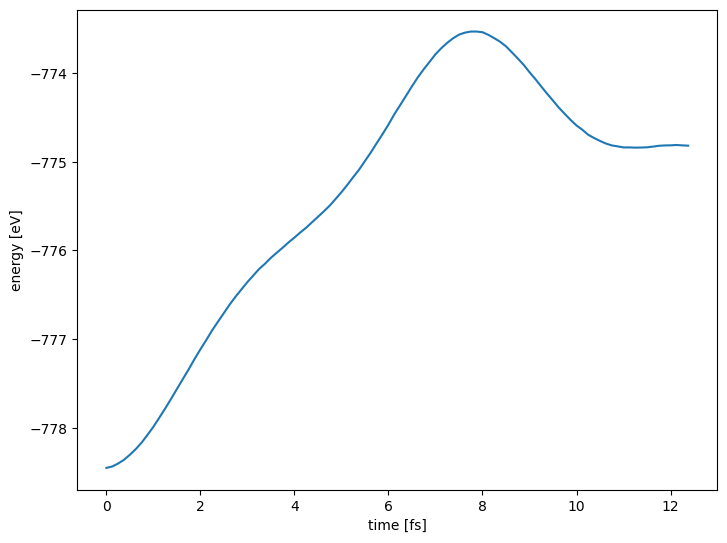

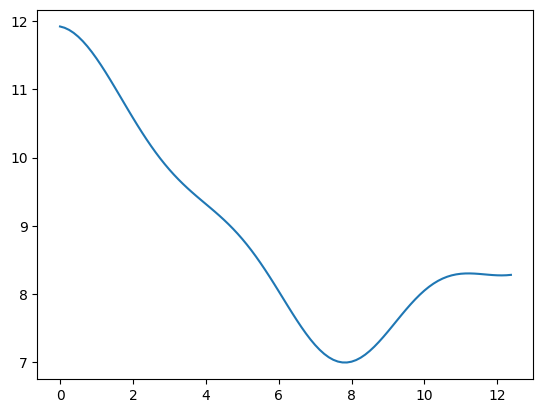

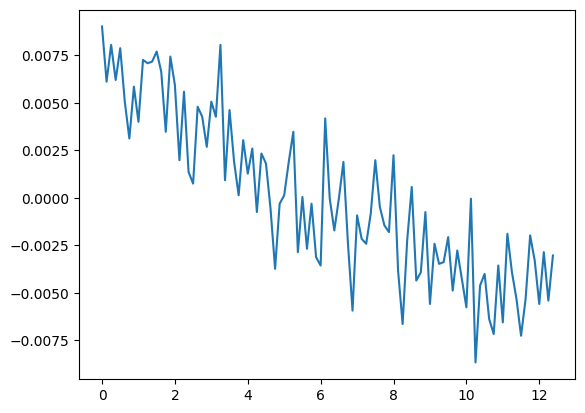

In [193]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

(array([ 3.,  5., 17., 18., 10., 22., 10.,  8.,  6.,  1.]),
 array([-3.25431824e-04, -2.55241394e-04, -1.85050964e-04, -1.14860535e-04,
        -4.46701050e-05,  2.55203247e-05,  9.57107544e-05,  1.65901184e-04,
         2.36091614e-04,  3.06282043e-04,  3.76472473e-04]),
 <BarContainer object of 10 artists>)

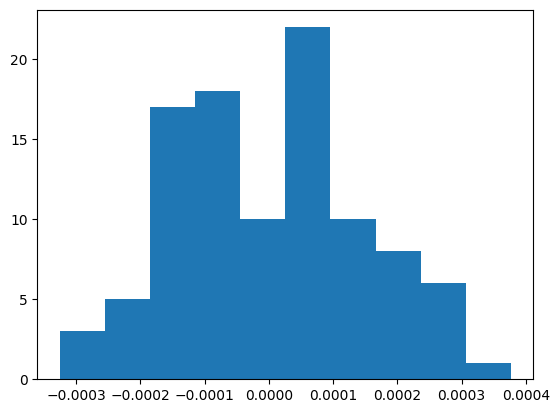

In [158]:
plt.hist(total_energy - total_energy.mean())